In [38]:
import pymysql
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.sql import text


In [42]:
db_user = "root"
db_password = "Equipament0"
db_host = "localhost"
db_port = "3306"
db_name = "project_nba"

connection = f"mysql+pymysql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

engine = create_engine(connection)




In [139]:
query_height_position = '''
# AVERAGE HEIGH PER POSITION
SELECT position,  AVG(height_cm) AS avg_height
FROM player_info
GROUP BY position;
'''

query_exp = '''
#PLAYER WITH MOST SEASONS EXPERIENCE FOR EACH TEAM

SELECT t.team_name, p.display_first_last, p.season_exp
FROM (
  SELECT team_id, MAX(season_exp) AS max_season_exp
  FROM player_info
  GROUP BY team_id
) AS max_exp
JOIN player_info p ON p.team_id = max_exp.team_id AND p.season_exp = max_exp.max_season_exp
JOIN team_info t ON t.team_id = p.team_id
ORDER BY t.team_name;
'''

query_rebounds = '''
# TEAMS WITH MOST REBOUNDS

SELECT ti.team_name, SUM(os.team_rebounds_home) AS total_home_rebounds, SUM(os.team_rebounds_away) AS total_away_rebounds, SUM(os.team_rebounds_home + os.team_rebounds_away) AS total_rebounds
FROM other_stats AS os
INNER JOIN team_info AS ti ON os.team_id_home = ti.team_id
GROUP BY ti.team_name
ORDER BY total_rebounds DESC;
'''


query_turnovers = '''
#TEAMS TURNOVERS HOME VS AWAY

SELECT t.team_name,
       sum(os.team_turnovers_home) AS total_turnovers_home,
       sum(os.team_turnovers_away) AS total_turnovers_away

FROM team_info t
JOIN other_stats os
ON t.team_id = os.team_id_home OR t.team_id = os.team_id_away
GROUP BY t.team_name
ORDER BY total_turnovers_home desc;
'''

query_avg_turnovers = '''
# TEAMS WITH MOST AVG TURNOVERS PER GAME
SELECT t.team_name, AVG(g.tov_home + g.tov_away) AS avg_turnovers_per_game
FROM team_info t
JOIN game g ON t.team_id = g.team_id_home OR t.team_id = g.team_id_away
GROUP BY t.team_name
ORDER BY avg_turnovers_per_game DESC;
'''

query_leads = '''
#TEAM LEADS HOME VS AWAY

SELECT t.team_name,
       SUM(CASE WHEN os.team_id_home = t.team_id THEN os.lead_changes ELSE 0 END) AS lead_changes_home,
       SUM(CASE WHEN os.team_id_away = t.team_id THEN os.lead_changes ELSE 0 END) AS lead_changes_away
FROM team_info t
JOIN other_stats os
ON t.team_id = os.team_id_home OR t.team_id = os.team_id_away
GROUP BY t.team_name
ORDER BY lead_changes_home DESC;
'''

query_avg_pts = '''
# TEAMS AVERAGE POINST HOME AND AWAY

SELECT team_info.team_name, AVG(game.pts_home) AS avg_points_home, AVG(game.pts_away) AS avg_points_away
FROM game
JOIN team_info ON game.team_id_home = team_info.team_id OR game.team_id_away = team_info.team_id
GROUP BY team_info.team_name;
'''

In [140]:
# Execute the SQL query using the engine
df_height = pd.read_sql_query(sql=text(query_height_position), con=engine.connect())
df_exp = pd.read_sql_query(sql=text(query_exp), con=engine.connect())
df_rebounds = pd.read_sql_query(sql=text(query_rebounds), con=engine.connect())
df_turnovers = pd.read_sql_query(sql=text(query_turnovers), con=engine.connect())
df_avg_turnovers = pd.read_sql_query(sql=text(query_avg_turnovers), con=engine.connect())
df_leads = pd.read_sql_query(sql=text(query_leads), con=engine.connect())
df_avg_pts = pd.read_sql_query(sql=text(query_avg_pts), con=engine.connect())


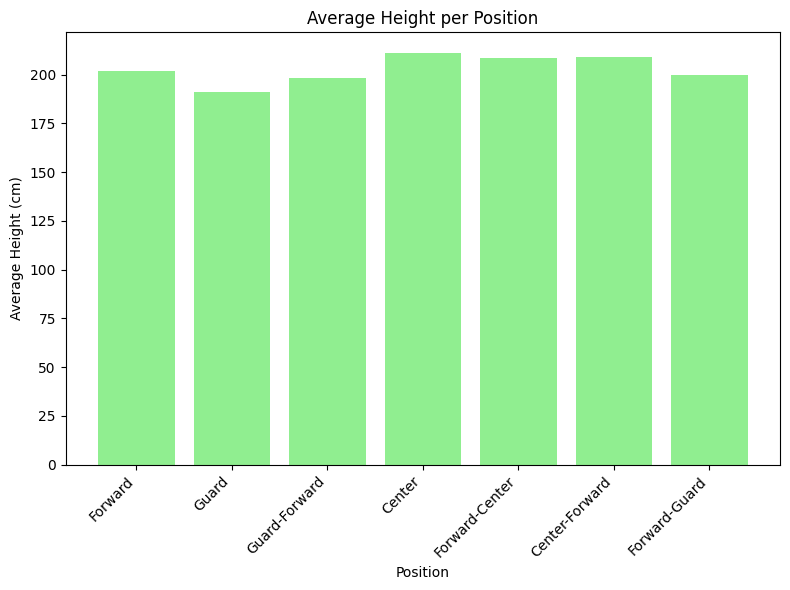

In [176]:
# Visualization for height per position

plt.figure(figsize=(8, 6))

plt.bar(df_height['position'], df_height['avg_height'], color='lightgreen')
bar_width= 0.3
plt.xlabel('Position')
plt.ylabel('Average Height (cm)')
plt.title('Average Height per Position')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()



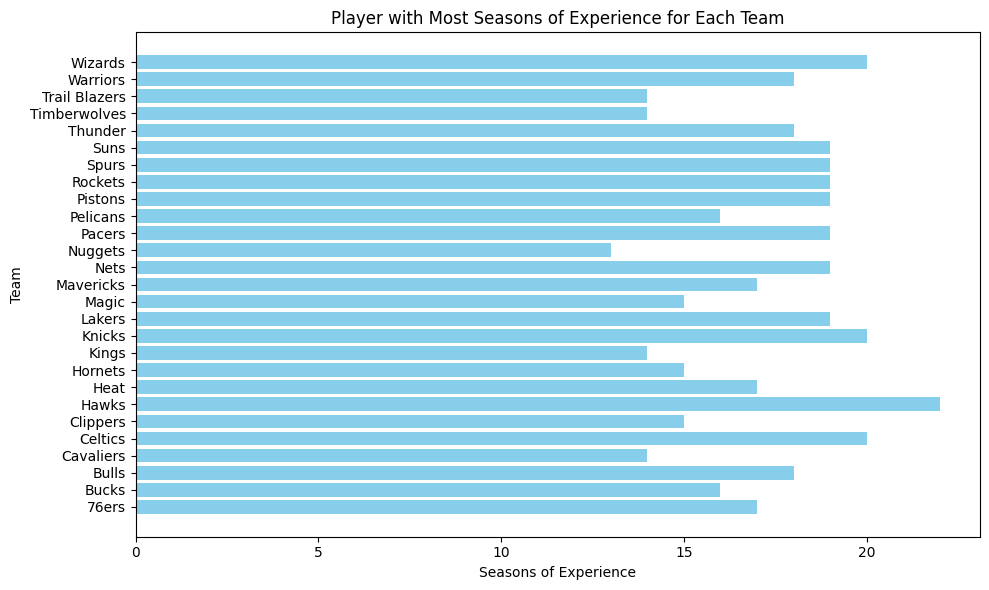

In [163]:
# Visualization for experience players 

plt.figure(figsize=(10, 6))

plt.barh(df_exp['team_name'], df_exp['season_exp'], color='skyblue')
plt.xlabel('Seasons of Experience')
plt.ylabel('Team')
plt.title('Player with Most Seasons of Experience for Each Team')
plt.tight_layout()

plt.show()

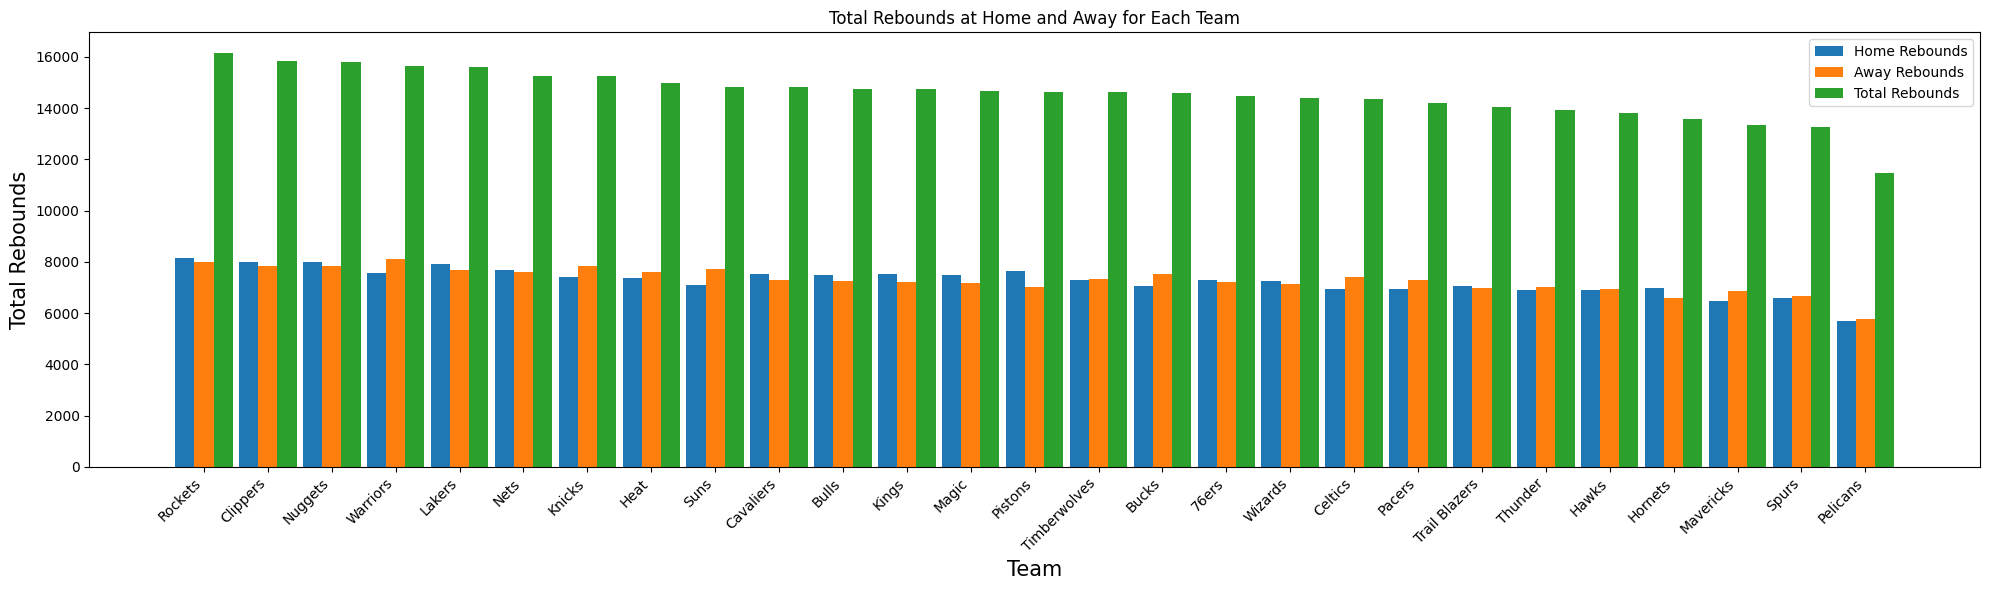

In [162]:
# Visualization for rebounds 

plt.figure(figsize=(20, 6))
bar_width = 0.3

plt.bar(df_rebounds.index - bar_width, df_rebounds['total_home_rebounds'], bar_width, label='Home Rebounds')
plt.bar(df_rebounds.index, df_rebounds['total_away_rebounds'], bar_width, label='Away Rebounds')
plt.bar(df_rebounds.index + bar_width, df_rebounds['total_rebounds'], bar_width, label='Total Rebounds')

plt.xlabel('Team', fontsize=15)
plt.ylabel('Total Rebounds', fontsize=15)
plt.title('Total Rebounds at Home and Away for Each Team')
plt.xticks(df_rebounds.index, df_rebounds['team_name'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

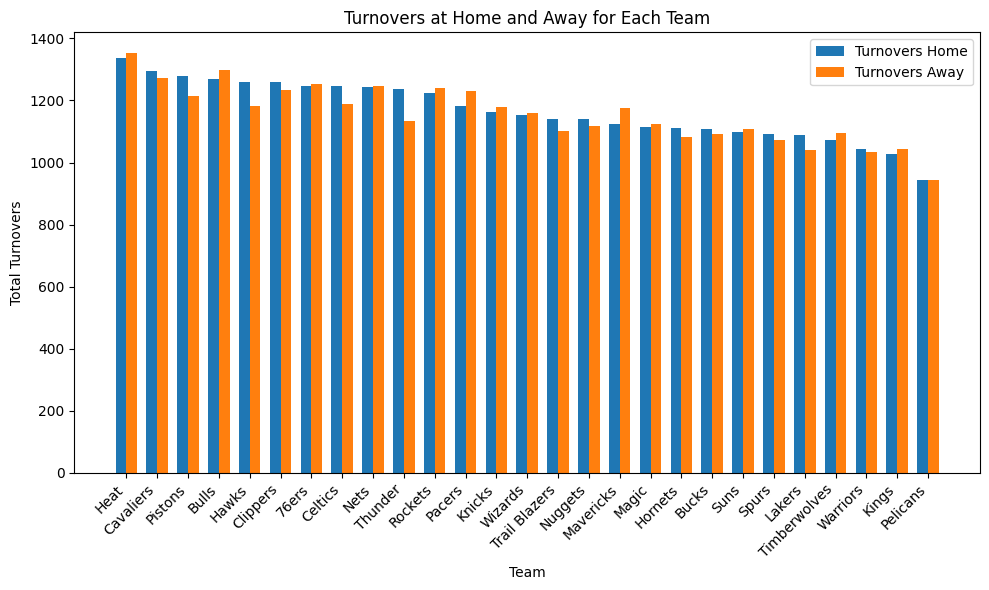

In [154]:
# Visualization for turnovers

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(df_turnovers.index - bar_width/2, df_turnovers['total_turnovers_home'], bar_width, label='Turnovers Home')
plt.bar(df_turnovers.index + bar_width/2, df_turnovers['total_turnovers_away'], bar_width, label='Turnovers Away')

plt.xlabel('Team')
plt.ylabel('Total Turnovers')
plt.title('Turnovers at Home and Away for Each Team')
plt.xticks(df_turnovers.index, df_turnovers['team_name'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

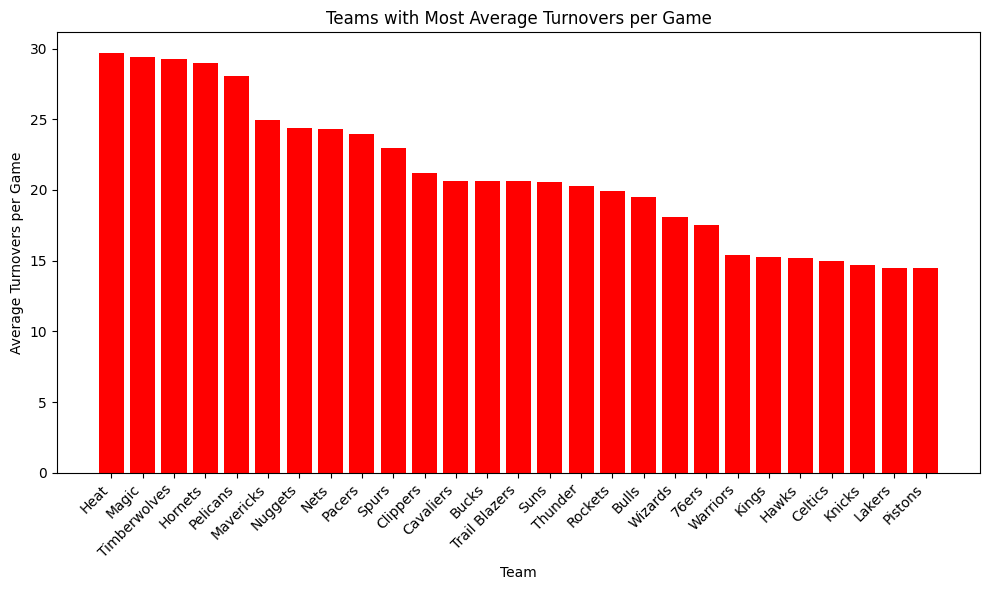

In [177]:
# Visualization for Teams with Most Average Turnovers per Game

plt.figure(figsize=(10, 6))
plt.bar(df_avg_turnovers['team_name'], df_avg_turnovers['avg_turnovers_per_game'], color='red')

plt.xlabel('Team')
plt.ylabel('Average Turnovers per Game')
plt.title('Teams with Most Average Turnovers per Game')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

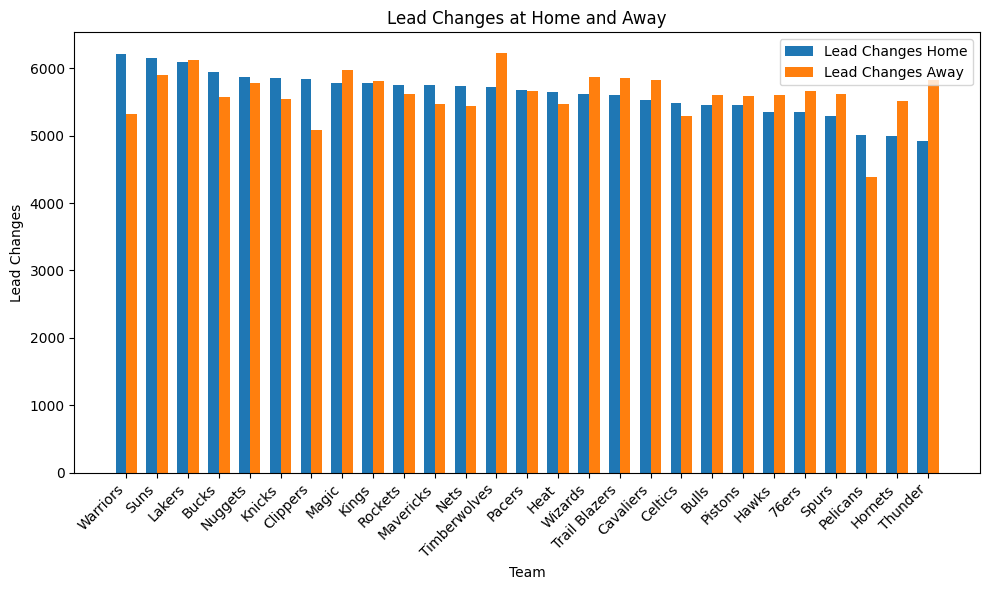

In [149]:
# Visualization for the leads query


# Create a grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(df_leads.index - bar_width/2, df_leads['lead_changes_home'], bar_width, label='Lead Changes Home')
plt.bar(df_leads.index + bar_width/2, df_leads['lead_changes_away'], bar_width, label='Lead Changes Away')

plt.xlabel('Team')
plt.ylabel('Lead Changes')
plt.title('Lead Changes at Home and Away')
plt.xticks(df_leads.index, df_leads['team_name'], rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()

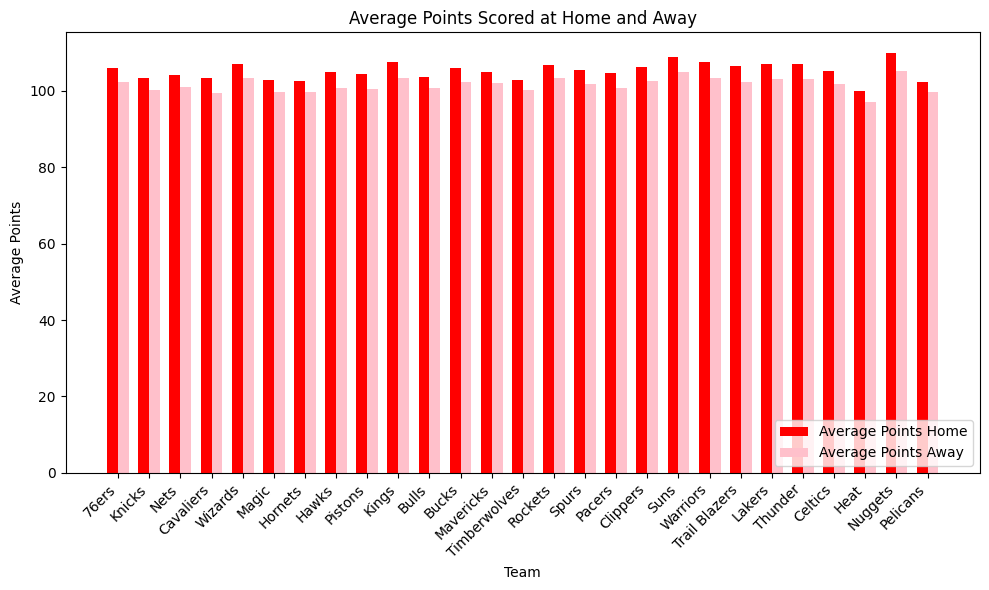

In [186]:
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(df_avg_pts.index - bar_width/2, df_avg_pts['avg_points_home'], bar_width, label='Average Points Home', color = 'red')
plt.bar(df_avg_pts.index + bar_width/2, df_avg_pts['avg_points_away'], bar_width, label='Average Points Away', color = 'pink')

plt.xlabel('Team')
plt.ylabel('Average Points')
plt.title('Average Points Scored at Home and Away')
plt.xticks(df_avg_pts.index, df_avg_pts['team_name'], rotation=45, ha='right')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()